# Final Project: Santander Customer Satisfaction

## Name: Rafael Villalobos

In [ ]:
pip install tensorflow
pip install lightgbm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# The 'TARGET' column is the variable to predict. It equals 1 for unsatisfied and 0 for satisfied customers

# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Training set shape: (76020, 371)
Test set shape: (75818, 370)

Data types in the training set:
ID                           int64
var3                         int64
var15                        int64
imp_ent_var16_ult1         float64
imp_op_var39_comer_ult1    float64
                            ...   
saldo_medio_var44_hace3    float64
saldo_medio_var44_ult1     float64
saldo_medio_var44_ult3     float64
var38                      float64
TARGET                       int64
Length: 371, dtype: object

Basic statistics for the training set:
                  ID           var3         var15  imp_ent_var16_ult1  \
count   76020.000000   76020.000000  76020.000000        76020.000000   
mean    75964.050723   -1523.199277     33.212865           86.208265   
std     43781.947379   39033.462364     12.956486         1614.757313   
min         1.000000 -999999.000000      5.000000            0.000000   
25%     38104.750000       2.000000     23.000000            0.000000   
50%     76043.0

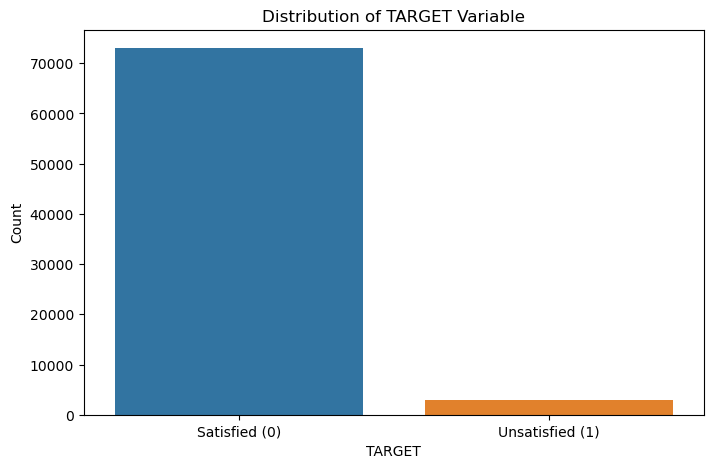

In [2]:
# Check the size of the datasets
print(f"Training set shape: {train.shape}")
print(f"Test set shape: {test.shape}")

# Check the data types of each column
print("\nData types in the training set:")
print(train.dtypes)

# Basic statistics to understand the features
print("\nBasic statistics for the training set:")
print(train.describe())

# Check the distribution of TARGET variable
target_counts = train['TARGET'].value_counts()
print(target_counts)

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=target_counts.index, y=target_counts.values)
plt.xlabel('TARGET')
plt.ylabel('Count')
plt.title('Distribution of TARGET Variable')
plt.xticks([0, 1], ['Satisfied (0)', 'Unsatisfied (1)'])
plt.show()

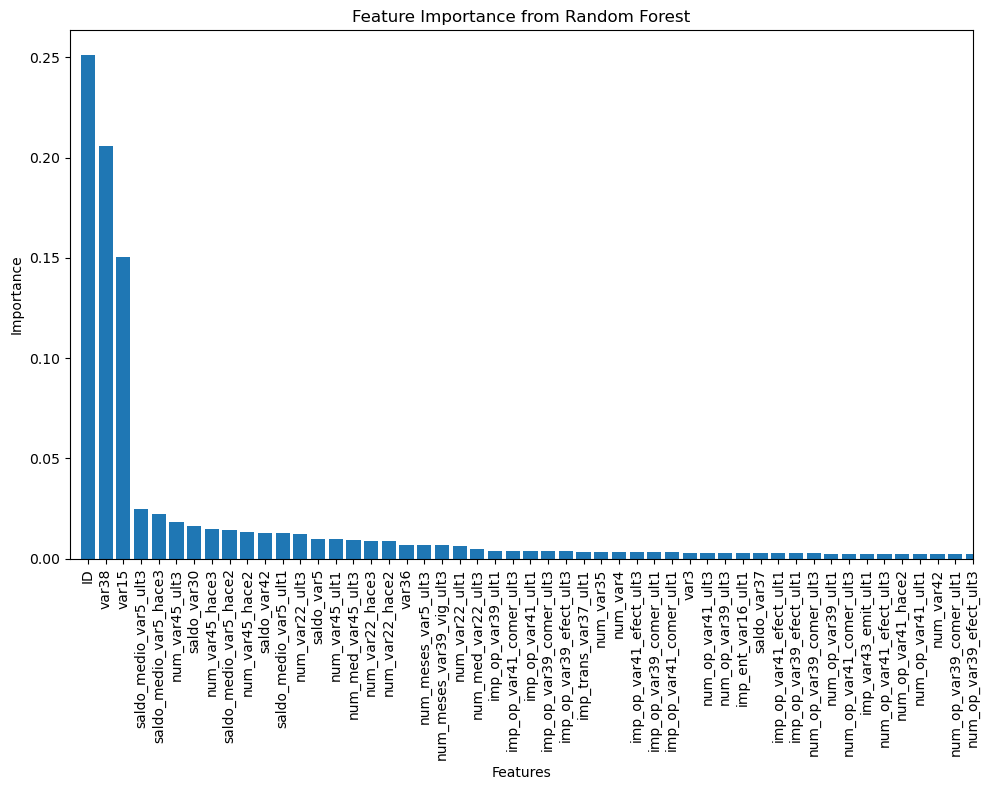

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importances from the trained model
feature_importances = pipeline.named_steps['classifier'].feature_importances_
features = X.columns

# Plot feature importance
plt.figure(figsize=(10, 8))
indices = np.argsort(feature_importances)[::-1]
plt.bar(range(len(features)), feature_importances[indices], align='center')
plt.xticks(range(len(features)), features[indices], rotation=90)
plt.xlim(-1, 50)  # Only show x values
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.show()


In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample

# Model 1: RandomForestClassifer (Decision Tree)

# Step 1: Load the data
df = pd.read_csv('train.csv')

df_majority = df[df['TARGET'] == 1]
df_minority = df[df['TARGET'] == 0]

# Step 2: Upsample minority class
df_minority_upsampled = resample(df_minority, replace = True, n_samples = len(df_majority), random_state = 42)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Step 3: Separate features and target after resampling
X = df_upsampled.drop(columns=['TARGET'])
y = df_upsampled['TARGET']

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 6: Make predictions
y_pred = rf_model.predict(X_test)

# Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       578
           1       0.76      0.76      0.76       626

    accuracy                           0.75      1204
   macro avg       0.75      0.75      0.75      1204
weighted avg       0.75      0.75      0.75      1204

[[428 150]
 [151 475]]


In [33]:
# Model 2: RandomForestClassifer with only the 2 most importnat features

# Step 1: Load the data
df = pd.read_csv('train.csv')

df_majority = df[df['TARGET'] == 1]
df_minority = df[df['TARGET'] == 0]

# Step 2: Upsample minority class
df_minority_upsampled = resample(df_minority, replace = True, n_samples = len(df_majority), random_state = 42)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Step 3: Separate features and target after resampling
X = df_upsampled[['var38', 'var15']]
y = df_upsampled['TARGET']

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 6: Make predictions
y_pred = rf_model.predict(X_test)

# Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

Accuracy: 0.62
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       578
           1       0.63      0.65      0.64       626

    accuracy                           0.62      1204
   macro avg       0.62      0.62      0.62      1204
weighted avg       0.62      0.62      0.62      1204

[[342 236]
 [218 408]]


In [49]:
import lightgbm as lgb

# Model 4: LightGBM (Ensemble Methods

# Step 1: Load the data
df = pd.read_csv('train.csv')

df_majority = df[df['TARGET'] == 1]
df_minority = df[df['TARGET'] == 0]

# Step 2: Upsample minority class
df_minority_upsampled = resample(df_minority, replace = True, n_samples = len(df_majority), random_state = 42)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Step 3: Separate features and target after resampling
X = df_upsampled.drop(columns=['TARGET'])
y = df_upsampled['TARGET']

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Set hyperparameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Step 5: Train the LightGBM model
model = lgb.train(params, train_data, valid_sets=[train_data, test_data])

# Step 6: Make predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

Accuracy: 0.77
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       578
           1       0.78      0.79      0.78       626

    accuracy                           0.77      1204
   macro avg       0.77      0.77      0.77      1204
weighted avg       0.77      0.77      0.77      1204

[[435 143]
 [130 496]]
